# Simulations for the main text.
Original version: 06/28/2018. This version: 07/29/2019 (pyGSTi compatability updates).

This notebook contains code to:
1. Generate the data used for the simulations presented in the main text (see Fig. 3).
2. The data analysis we used.
To use this notebook it is necessary to install the python package `pyGSTi` http://www.pygsti.info. This notebook should be used with `pygSTi` version 0.9.8, the latest version as of this writing.

This notebook uses various features of `pyGSTi` without detailed explanations. For further information on using `pyGSTi` for DRB see: 
- The experiment data analysis notebook, in this supplemental material.
- The RB tutorial notebooks contained within `pyGSTi`.
- The `pyGSTi` docstrings.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports for python2 compatability.
from __future__ import division, print_function, absolute_import, unicode_literals

# pyGSTi imports. This code requires pyGSTi version 0.9.5
import pygsti
from pygsti.extras import rb

The number of qubits:

In [2]:
nlist = [2,4,6,8,10,12,14]

The gate error rates (the error model is specified in the main text):

In [3]:
# The 1-qubit gate error rate (including idle gates).
oneq_er = 0.0005
# The error rate of each qubit in the CNOT (approximately 1/2 the CNOT error rate)
perQ_cnot_er = 0.0025
# The CNOT error rate
CNOT_error_rate = 1-(1-perQ_cnot_er)**2

# Data generation
Code to generate data, which is skipped if `dosims` is False.

These simulations will take a long time to run, although adjustments can be made to the circuit generation spec to speed it up (or it can be fairly quickly run for RB on fewer qubits). We used an MPI version of this notebook to create the data; we have not tested how long the following cells take to run on a single core (but it is probably many days).

In [4]:
dosims = False

This creates information about the (imaginary) device, and generates the error model. This cell should be quick to run.

In [5]:
if dosims:     

    # ------------------------------------------------------ #
    #            The DRB and CRD specifications
    # ------------------------------------------------------ #
    
    lengths = {}
    # The DRB lengths
    lengths['DRB'] = np.array([0,25,50,75,100,125,150,175,200])
    # The CRB lengths (the number of Cliffords - 2, unlike some conventions)
    lengths['CRB'] = np.array([0,1,2,3,4,5,6,7,8])
    
    # The DRB circuit sampler name (for the inbuilt samplers in pyGSTi.extras.rb)
    sampler = 'pairingQs'
    # Arguments passed to the "core" circuit sampler. This 1-element list specifies
    # the probability of a CNOT being applied to a pair (see main text for details).
    samplerargs = [0.5,]
    
    # Whether each random layer in DRB is followed by a random layer of 1-qubit gates.
    addlocal = False
    # Args for the local layers sampler.
    lsargs = []
    
    # Whether to randomize the ideal circuit output
    randomizeout = False
    
    # The number of iterations in the randomized stabilizer compiler.
    drb_citerations = 200
    # We use the default in-built stabilizer compiler. In future versions of pyGSTi the default
    # compiler will likely be improved, so quantively different results may then be
    # obtained (although the DRB error rates should not change).
    drb_compilerargs = []
    
    # The number of iterations in the randomized Clifford compiler. We use less iterations
    # here, as every element in the CRB sequence has to be compiled, so the total iterations is
    # crb_citerations X the uncompiled CRB circuit length. There is no specific value that is 
    # unambigously the "fair" comparison between DRB and CRB.
    crb_citerations = 20
    # We use the default in-built Clifford compiler. In future versions of pyGSTi the default
    # compiler will likely be improved, so quantively different results may then be
    # obtained (the CRB error rates may change).
    crb_compilerargs = []
    
    # The number of circuits per length
    k = 30
    # The repeats per circuit
    N = 40
        
    rbspec = {}
    # The parameters set here to "True" are required for implementing the direct RB protocol (
    # (rather than minor variants on direct RB).
    rbspec['DRB'] = [sampler, samplerargs, addlocal, lsargs, randomizeout, True, True, drb_citerations, 
                     drb_compilerargs]
    rbspec['CRB'] = [randomizeout, crb_citerations, crb_compilerargs]

    # The gateset used: idle, Hadamard, phase and CNOT.
    gllist = ['Gi','Gh','Gp','Gcnot']
    
    # -------------------------------------------------------------------------- #
    #     Constructing the error model, and the (imaginary) device specification
    # -------------------------------------------------------------------------- #
        
    # To hold "ProcessorSpec" objects.
    pspec = {}
    # To encode the error model in the appropriate format for the simulator.
    errormodel = {}
    for n in nlist:        
        # Because we do not specify otherwise, the device is assumed to have full connectivity
        pspec[n] = pygsti.obj.ProcessorSpec(n, gllist, verbosity=0)      
        errormodel[n] = rb.simulate.create_iid_pauli_error_model(pspec[n] ,oneq_er, CNOT_error_rate,
                                                          idle_errorrate = oneq_er)

This cell generates the data, using the `pyGSTi` RB simulator (which samples circuits, simulates them, and writes the data to file; see the `pyGSTi` docstrings for further information). It will take a long time to run.

In [6]:
if dosims:
    base_filename = "main_simulation_newdata"
    for n in nlist:
        for rbtype in ['DRB','CRB']:
            print('')
            print("-------- {} Simulations on {} qubits --------".format(rbtype,n),end='\n\n')
            filename = base_filename + '_{}_on_{}_qubits.txt'.format(rbtype,n)
            rb.simulate.rb_with_pauli_errors(pspec[n], errormodel[n], lengths[rbtype], k, N, subsetQs=None,
                                             filename=filename, rbtype=rbtype, rbspec=rbspec[rbtype],  
                                             returndata=False, appenddata=False, verbosity=1)

# Analyzing the data
We now analyze the previously generated data, stored in the files "main_simulation_data_xRB_on_n_qubits.txt", with the x and n taking the obvious values for the various qubit-number / RB-type cases.

This uses the same `pyGSTi` functions as the analysis of the IBMQX5 experimental data; see that notebook and/or the `pyGSTi` docstrings and tutorials for information on the functions used.

In [7]:
# A dictionary to hold the data for each RB-type qubit-number pair
data = {}
for n in nlist:
    for rbtype in ['DRB','CRB']:
        filename = "main_simulation_data_{}_on_{}_qubits.txt".format(rbtype,n)
        data[rbtype,n] = rb.io.import_rb_summary_data(filename)

Importing main_simulation_data_DRB_on_2_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_2_qubits.txt...Complete.
Importing main_simulation_data_DRB_on_4_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_4_qubits.txt...Complete.
Importing main_simulation_data_DRB_on_6_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_6_qubits.txt...Complete.
Importing main_simulation_data_DRB_on_8_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_8_qubits.txt...Complete.
Importing main_simulation_data_DRB_on_10_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_10_qubits.txt...Complete.
Importing main_simulation_data_DRB_on_12_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_12_qubits.txt...Complete.
Importing main_simulation_data_DRB_on_14_qubits.txt...Complete.
Importing main_simulation_data_CRB_on_14_qubits.txt...Complete.


In [8]:
# Generates bootstrapped datasets.
bootstraps = 2000
for n in nlist:
    for rbtype in ['DRB','CRB']:
        print("Generating bootstraps for {} data on {} qubits... ".format(rbtype,n),end='')
        data[rbtype,n].add_bootstrapped_datasets(bootstraps)
        print("complete.")

Generating bootstraps for DRB data on 2 qubits... complete.
Generating bootstraps for CRB data on 2 qubits... complete.
Generating bootstraps for DRB data on 4 qubits... complete.
Generating bootstraps for CRB data on 4 qubits... complete.
Generating bootstraps for DRB data on 6 qubits... complete.
Generating bootstraps for CRB data on 6 qubits... complete.
Generating bootstraps for DRB data on 8 qubits... complete.
Generating bootstraps for CRB data on 8 qubits... complete.
Generating bootstraps for DRB data on 10 qubits... complete.
Generating bootstraps for CRB data on 10 qubits... complete.
Generating bootstraps for DRB data on 12 qubits... complete.
Generating bootstraps for CRB data on 12 qubits... complete.
Generating bootstraps for DRB data on 14 qubits... complete.
Generating bootstraps for CRB data on 14 qubits... complete.


In [9]:
# Seeds for B and p in A + Bp^m
seed = {}
# DRB seeds
seed['DRB',2] = [0.99, 0.997]
seed['DRB',4] = [0.9, 0.994]
seed['DRB',6] = [0.8,  0.991]
seed['DRB',8] = [0.6,  0.988]
seed['DRB',10] = [0.5,  0.985]
seed['DRB',12] = [0.32, 0.982]
seed['DRB',14] = [0.23,  0.979]
# CRB seeds
seed['CRB',2] = [0.99, 0.99]
seed['CRB',4] = [0.9, 0.9]
seed['CRB',6] = [0.8, 0.8]
seed['CRB',8] = [0.5, 0.5]
seed['CRB',10] = [0.3, 0.4]
seed['CRB',12] = [0.1, 0.2]
seed['CRB',14] = [0.05, 0.2]

# Dicts for storing information about the fit
estimates = {}
bootstrapped_r = {}
fitfailcount = {}
r = {}
r_std = {}
for n in nlist:
    for rbtype in ['DRB','CRB']:
        print("Analyzing {} data on {} qubits... ".format(rbtype,n),end='')
        # Fit the data, with the asymptotes fixed to 1/2^n
        lengths = data[rbtype,n].lengths
        ASPs = data[rbtype,n].ASPs
        fit = rb.analysis.std_least_squares_data_fitting(lengths, ASPs, n, seed=seed[rbtype,n], 
                                                                   asymptote=1/2**n, ftype='FA')
        if not fit['success']:
            print("Fit failed!")
        estimates[rbtype,n] = fit['estimates']
        
        # Repeat the analysis on the boostrapped data
        bootstrapped_r[rbtype,n] = []
        fitfailcount[rbtype,n] = 0
        for i in range(bootstraps):
            
            ASPs = data[rbtype,n].bootstraps[i].ASPs
            bsfit = rb.analysis.std_least_squares_data_fitting(lengths, ASPs, n, seed=seed[rbtype,n], 
                                                                   asymptote=1/2**n, ftype='FA')
            
            if bsfit['success']:
                bootstrapped_r[rbtype,n].append(bsfit['estimates']['r'])
            else:
                fitfailcount[rbtype,n] += 1
                
        r[rbtype,n] = estimates[rbtype,n]['r']
        r_std[rbtype,n] = np.std(np.array(bootstrapped_r[rbtype,n]))
        print('complete. (failcount = {}).'.format(fitfailcount[rbtype,n]))

Analyzing DRB data on 2 qubits... complete. (failcount = 0).
Analyzing CRB data on 2 qubits... complete. (failcount = 0).
Analyzing DRB data on 4 qubits... complete. (failcount = 0).
Analyzing CRB data on 4 qubits... complete. (failcount = 0).
Analyzing DRB data on 6 qubits... complete. (failcount = 0).
Analyzing CRB data on 6 qubits... complete. (failcount = 0).
Analyzing DRB data on 8 qubits... complete. (failcount = 0).
Analyzing CRB data on 8 qubits... complete. (failcount = 0).
Analyzing DRB data on 10 qubits... complete. (failcount = 0).
Analyzing CRB data on 10 qubits... complete. (failcount = 0).
Analyzing DRB data on 12 qubits... complete. (failcount = 0).
Analyzing CRB data on 12 qubits... complete. (failcount = 0).
Analyzing DRB data on 14 qubits... complete. (failcount = 0).
Analyzing CRB data on 14 qubits... complete. (failcount = 0).


In [10]:
# Prints the results
for rbtype in ['DRB','CRB']:
    for n in nlist:    
        print("{} on {} qubits, r = {:0.3} +/-  {:0.2}".format(rbtype,n,r[rbtype,n],r_std[rbtype,n]))
    print('')

DRB on 2 qubits, r = 0.00292 +/-  0.00013
DRB on 4 qubits, r = 0.00589 +/-  0.00019
DRB on 6 qubits, r = 0.00872 +/-  0.00028
DRB on 8 qubits, r = 0.0117 +/-  0.00042
DRB on 10 qubits, r = 0.0146 +/-  0.00061
DRB on 12 qubits, r = 0.0168 +/-  0.0011
DRB on 14 qubits, r = 0.022 +/-  0.0019

CRB on 2 qubits, r = 0.0176 +/-  0.0021
CRB on 4 qubits, r = 0.0988 +/-  0.0037
CRB on 6 qubits, r = 0.222 +/-  0.0069
CRB on 8 qubits, r = 0.38 +/-  0.015
CRB on 10 qubits, r = 0.588 +/-  0.035
CRB on 12 qubits, r = 0.668 +/-  0.054
CRB on 14 qubits, r = 0.891 +/-  0.069



In [11]:
# Data plotting function
def plot_data(data, estimates=None, size=(6,2), ylim=None):
    
    plt.figure(figsize=size)
    plt.plot(data.lengths,data.ASPs,'o')
    lengths = np.linspace(0,max(data.lengths),200)
    
    if estimates is not None:
        A = estimates['A']
        B = estimates['B']
        p = estimates['p']
        plt.plot(lengths,A+B*p**lengths)
    plt.violinplot(list(data.success_probabilities),data.lengths,points=10, widths=1., showmeans=True, 
                   showextrema=False, showmedians=False)
    
    plt.ylabel("Success probability")
    plt.xlabel("Seqence length")
    plt.ylim(ylim)
    
    plt.show()

We can look at the data + bootstraps for any RB-type / qubit-number pair

In [12]:
rbtype = 'CRB'
n = 14

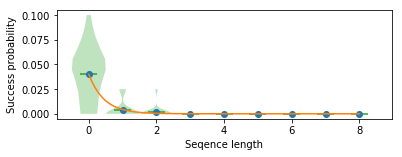

In [13]:
# For CRB, sequence length m consists of m + 2 cliffords.
# For DRB, sequence length m consists of a length m circuit in between the prep/measure circuits
plot_data(data[rbtype,n], estimates[rbtype,n], size=(6,2))

In [14]:
plt.hist(bootstrapped_r[rbtype,n],bins=30)
plt.show()

We now compare the results to the true error probability per random native gate sampled accord to the DRB sampling distribution.

Let $\epsilon_2$ denote the CNOT error probability, and let $\epsilon_1$ denote the error probability of a 2-qubit gate consisting of two parallel 1-qubit gates. With the sampling used here, the qubits are paired up (there are an even number of qubits) and a CNOT is applied to a pair with probability $0.5$, with 1-qubit gates being applied to each qubit otherwise. So, an $n$-qubit gate containing $m$ CNOTs is sampled with probability $ {n/2 \choose m}0.5^{m}0.5^{n/2-m}$ and that gate has an error rate of $ 1-(1-\epsilon_{1})^{m-n/2}(1-\epsilon_{2})^{m}$ . so the sampling-averaged error rate is
\begin{equation}
\epsilon = \sum_{m=0}^{n/2} {n/2 \choose m}0.5^{m}0.5^{n/2-m}\left[ 1-(1-\epsilon_{1})^{m-n/2}(1-\epsilon_{2})^{m}\right] 
= 1 - \left[\frac{1}{2}(1-\epsilon_{1}) + \frac{1}{2}(1-\epsilon_{2})\right]^{n/2}.
\end{equation}
In the following cell, we calculate $\epsilon$ (for each $n$) using this formula.

In [15]:
cnotprob = 0.5
cnot_error_rate = 1-(1-perQ_cnot_er)**2
two_oneQ_gates_error_rate = 1 - (1-oneq_er)**2
predicted_drb_r = {}
for n in nlist:
    temp = (1-cnotprob)*(1-two_oneQ_gates_error_rate) + cnotprob*(1-cnot_error_rate)
    predicted_drb_r[n] = 1-(temp)**(n/2)
    print("DRB on {} qubits, error rate eps = {:0.4}, (r - eps)/eps = {} ".format(n,predicted_drb_r[n],(r['DRB',n]-predicted_drb_r[n])/predicted_drb_r[n]))

DRB on 2 qubits, error rate eps = 0.002997, (r - eps)/eps = -0.026207111344113326 
DRB on 4 qubits, error rate eps = 0.005985, (r - eps)/eps = -0.015452534874508064 
DRB on 6 qubits, error rate eps = 0.008963, (r - eps)/eps = -0.027272632543123152 
DRB on 8 qubits, error rate eps = 0.01193, (r - eps)/eps = -0.016002029080828015 
DRB on 10 qubits, error rate eps = 0.01489, (r - eps)/eps = -0.016808820663412473 
DRB on 12 qubits, error rate eps = 0.01785, (r - eps)/eps = -0.058193586277715134 
DRB on 14 qubits, error rate eps = 0.02079, (r - eps)/eps = 0.060077220818467454 


Rescaled CRB error rates.

In [16]:
alpha_depth = {}
alpha_cnotcount = {}
for n in nlist:
    alpha_depth[n] = rb.analysis.rescaling_factor(data['CRB',n].lengths, 
                                               data['CRB',n].circuit_depths, offset=2)
    alpha_cnotcount[n] = rb.analysis.rescaling_factor(data['CRB',n].lengths, 
                                               data['CRB',n].circuit_twoQgate_counts, offset=2)

crb_r_depth_rescaled = {}
crb_r_cnotcount_rescaled = {}
crb_r_depth_rescaled_std = {}
crb_r_cnotcount_rescaled_std = {}
for n in nlist:
    
    p = rb.analysis.r_to_p(r['CRB',n],2**n)
    crb_r_depth_rescaled[n] = rb.analysis.p_to_r(p**(1/alpha_depth[n]),2**n)
    crb_r_cnotcount_rescaled[n] = rb.analysis.p_to_r(p**(1/alpha_cnotcount[n]),2**n)
    
    crb_r_depth_rescaled_std[n] = []
    crb_r_cnotcount_rescaled_std[n] = []

    for i in range(bootstraps):
        p = rb.analysis.r_to_p(bootstrapped_r['CRB',n][i],2**n)
        crb_r_depth_rescaled_std[n].append(rb.analysis.p_to_r(p**(1/alpha_depth[n]),2**n))
        crb_r_cnotcount_rescaled_std[n].append(rb.analysis.p_to_r(p**(1/alpha_cnotcount[n]),2**n))
    
    crb_r_depth_rescaled_std[n] = np.std(np.array(crb_r_depth_rescaled_std[n]))
    crb_r_cnotcount_rescaled_std[n] = np.std(np.array(crb_r_cnotcount_rescaled_std[n]))   
                                                         
    print("{}-qubit CRB r rescaled by mean Clifford depth = {:0.4} +/- {:0.2}".format(n,crb_r_depth_rescaled[n],crb_r_depth_rescaled_std[n]))
    print("{}-qubit CRB r rescaled by mean CNOT count per Clifford = {:0.4} +/- {:0.2}".format(n,crb_r_cnotcount_rescaled[n],crb_r_cnotcount_rescaled_std[n]))
    print("")

2-qubit CRB r rescaled by mean Clifford depth = 0.001627 +/- 0.00019
2-qubit CRB r rescaled by mean CNOT count per Clifford = 0.00831 +/- 0.00098

4-qubit CRB r rescaled by mean Clifford depth = 0.003916 +/- 0.00016
4-qubit CRB r rescaled by mean CNOT count per Clifford = 0.01024 +/- 0.00041

6-qubit CRB r rescaled by mean Clifford depth = 0.00532 +/- 0.00019
6-qubit CRB r rescaled by mean CNOT count per Clifford = 0.009887 +/- 0.00035

8-qubit CRB r rescaled by mean Clifford depth = 0.006509 +/- 0.00034
8-qubit CRB r rescaled by mean CNOT count per Clifford = 0.009679 +/- 0.0005

10-qubit CRB r rescaled by mean Clifford depth = 0.00866 +/- 0.00085
10-qubit CRB r rescaled by mean CNOT count per Clifford = 0.01089 +/- 0.0011

12-qubit CRB r rescaled by mean Clifford depth = 0.008266 +/- 0.0013
12-qubit CRB r rescaled by mean CNOT count per Clifford = 0.009074 +/- 0.0014

14-qubit CRB r rescaled by mean Clifford depth = 0.01335 +/- 0.012
14-qubit CRB r rescaled by mean CNOT count per Cli